In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [13]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3540
    obs: 'cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count'

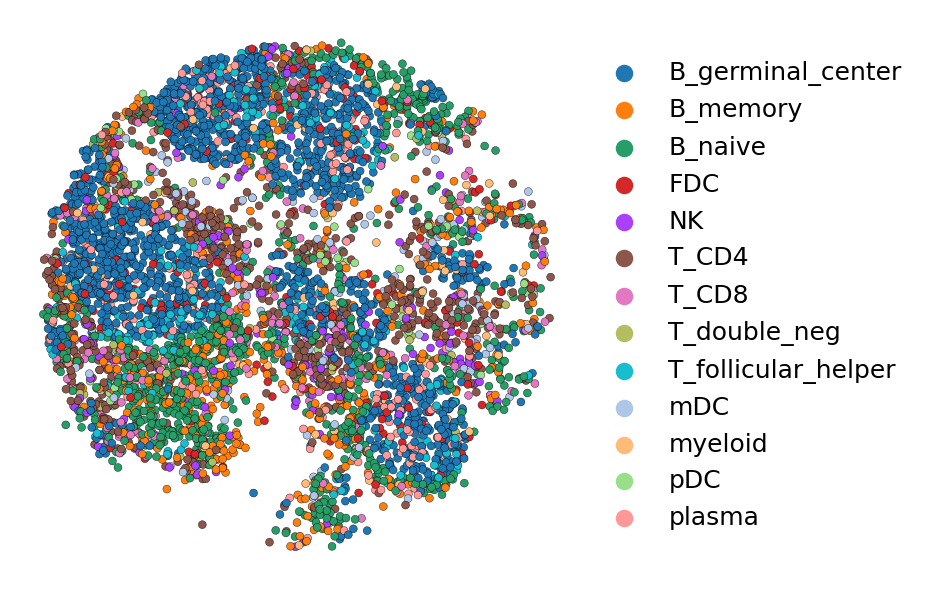

In [28]:
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180
sc.pl.embedding(adata, basis='spatial', color='cell_type', 
    frameon=False, edgecolor='black', s=40, linewidth=0.15, title='')


In [4]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [5]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

CPU times: user 3min 37s, sys: 1min 16s, total: 4min 54s
Wall time: 45.6 s


In [7]:
adata.X.max()

8.8678228953803

In [8]:
adata.layers["raw_count"] = np.exp(adata.X) - 1

In [9]:
adata

AnnData object with n_obs × n_vars = 5778 × 3540
    obs: 'cell_type', 'cell_type_int'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

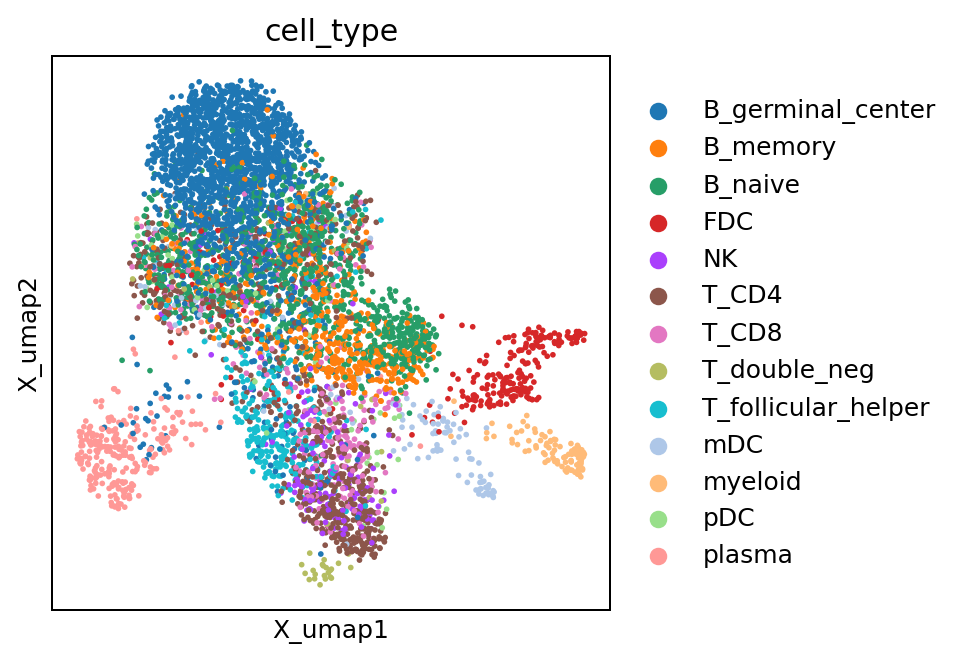

In [11]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [12]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [14]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=10,
    verbose_level=2
)

  0%|          | 0/13 [00:00<?, ?it/s]

Inferring GRN for B_germinal_center...


  0%|          | 0/3413 [00:00<?, ?it/s]

  8%|▊         | 1/13 [01:27<17:30, 87.54s/it]

Inferring GRN for B_memory...


  0%|          | 0/3413 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [02:48<15:22, 83.82s/it]

Inferring GRN for B_naive...


  0%|          | 0/3413 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [04:12<13:56, 83.68s/it]

Inferring GRN for FDC...


  0%|          | 0/3413 [00:00<?, ?it/s]

 31%|███       | 4/13 [05:33<12:23, 82.63s/it]

Inferring GRN for NK...


  0%|          | 0/3413 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [06:56<11:02, 82.75s/it]

Inferring GRN for T_CD4...


  0%|          | 0/3413 [00:00<?, ?it/s]

 46%|████▌     | 6/13 [08:22<09:46, 83.82s/it]

Inferring GRN for T_CD8...


  0%|          | 0/3413 [00:00<?, ?it/s]

 54%|█████▍    | 7/13 [09:45<08:21, 83.61s/it]

Inferring GRN for T_double_neg...


  0%|          | 0/3413 [00:00<?, ?it/s]

 62%|██████▏   | 8/13 [11:05<06:53, 82.67s/it]

Inferring GRN for T_follicular_helper...


  0%|          | 0/3413 [00:00<?, ?it/s]

 69%|██████▉   | 9/13 [12:28<05:30, 82.51s/it]

Inferring GRN for mDC...


  0%|          | 0/3413 [00:00<?, ?it/s]

 77%|███████▋  | 10/13 [13:49<04:06, 82.10s/it]

Inferring GRN for myeloid...


  0%|          | 0/3413 [00:00<?, ?it/s]

 85%|████████▍ | 11/13 [15:13<02:45, 82.76s/it]

Inferring GRN for pDC...


  0%|          | 0/3413 [00:00<?, ?it/s]

 92%|█████████▏| 12/13 [16:38<01:23, 83.28s/it]

Inferring GRN for plasma...


  0%|          | 0/3413 [00:00<?, ?it/s]

100%|██████████| 13/13 [18:03<00:00, 83.35s/it]

CPU times: user 12min 39s, sys: 38.3 s, total: 13min 17s
Wall time: 18min 3s


In [15]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/13 [00:00<?, ?it/s]

In [16]:
import pickle

with open('/Users/koush/Desktop/training_data/snrna_human_tonsil_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [17]:
adata

AnnData object with n_obs × n_vars = 5778 × 3540
    obs: 'cell_type', 'cell_type_int'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [19]:
links.links_dict.keys()

dict_keys(['B_germinal_center', 'B_memory', 'B_naive', 'FDC', 'NK', 'T_CD4', 'T_CD8', 'T_double_neg', 'T_follicular_helper', 'mDC', 'myeloid', 'pDC', 'plasma'])